In [1]:
import time

import numpy as np
import pandas as pd
import seaborn as sns

from uncertainties import ufloat
from ctypes import c_double

import ROOT
ROOT.EnableImplicitMT()    # Tells ROOT to go parallel

Welcome to JupyROOT 6.28/00


In [2]:
import os

sig_tag  = 'stop_M1000_988_ct200_2018'


bkg_dir = "/scratch-cbe/users/alikaan.gueven/AN_plots/ParT_hists/vtx_2018_v11/bkg"
sig_dir = "/scratch-cbe/users/alikaan.gueven/AN_plots/ParT_hists/vtx_2018_v11/sig"


sig_file = ROOT.TFile(os.path.join(sig_dir, f"{sig_tag}_hist.root"))
sig_hist = sig_file.all_evt.MET_pt_corr_vs_SPs_MaxLxySig.Clone()


bkg_file = ROOT.TFile(os.path.join(bkg_dir, f"all_2018_hist.root"))
bkg_hist = bkg_file.all_evt.MET_pt_corr_vs_SPs_MaxLxySig.Clone()

In [3]:
x_binwidth = sig_hist.GetXaxis().GetBinWidth(1)
y_binwidth = sig_hist.GetYaxis().GetBinWidth(1)
print(x_binwidth, y_binwidth)

10.0 4.0


In [4]:
MET_step = 50
LxySig_step = y_binwidth

MET_boundaryList = range(200+ MET_step, 1000+1, MET_step)
LxySig_boundaryList = np.arange(4, 40, LxySig_step)

# MLScore_boundaryList = np.arange(0.90, 1, MLScore_step)


In [5]:
def sig(s,b,b_err):
  return np.sqrt(2*((s+b)*np.log(((s+b)*(b+b_err*b_err))/(b*b+(s+b)*b_err*b_err+1e-100)) - 
                    (b*b/(b_err*b_err + 1e-100))*np.log(1+(b_err*b_err*s)/(b*(b+b_err*b_err)+1e-100))))

In [6]:
significances_dir = '/scratch-cbe/users/alikaan.gueven/AN_plots/ParT_hists/vtx_2018_v11/significances'
os.makedirs(significances_dir, exist_ok=True)

In [7]:
y_binwidth

4.0

In [8]:
MET_step = MET_boundaryList[1] - MET_boundaryList[0]
MLScore_step = LxySig_boundaryList[1] - LxySig_boundaryList[0]

sigTable = pd.DataFrame(columns=range(MET_boundaryList[0], MET_boundaryList[-1]+MET_step, MET_step),
                 index=  np.arange(LxySig_boundaryList[0], LxySig_boundaryList[-1]+MLScore_step, MLScore_step),
                 dtype= float)

bkgTable = pd.DataFrame(columns=range(MET_boundaryList[0], MET_boundaryList[-1]+MET_step, MET_step),
                 index=  np.arange(LxySig_boundaryList[0], LxySig_boundaryList[-1]+MLScore_step, MLScore_step),
                 dtype= float)

bkgpredTable = pd.DataFrame(columns=range(MET_boundaryList[0], MET_boundaryList[-1]+MET_step, MET_step),
                 index=  np.arange(LxySig_boundaryList[0], LxySig_boundaryList[-1]+MLScore_step, MLScore_step),
                 dtype= float)

bkgUncTable = pd.DataFrame(columns=range(MET_boundaryList[0], MET_boundaryList[-1]+MET_step, MET_step),
                 index=  np.arange(LxySig_boundaryList[0], LxySig_boundaryList[-1]+MLScore_step, MLScore_step),
                 dtype= float)

bkgpredUncTable = pd.DataFrame(columns=range(MET_boundaryList[0], MET_boundaryList[-1]+MET_step, MET_step),
                 index=  np.arange(LxySig_boundaryList[0], LxySig_boundaryList[-1]+MLScore_step, MLScore_step),
                 dtype= float)

signifTable = pd.DataFrame(columns=range(MET_boundaryList[0], MET_boundaryList[-1]+MET_step, MET_step),
                 index=  np.arange(LxySig_boundaryList[0], LxySig_boundaryList[-1]+MLScore_step, MLScore_step),
                 dtype= float)

signifpredTable = pd.DataFrame(columns=range(MET_boundaryList[0], MET_boundaryList[-1]+MET_step, MET_step),
                 index=  np.arange(LxySig_boundaryList[0], LxySig_boundaryList[-1]+MLScore_step, MLScore_step),
                 dtype= float)


store = pd.HDFStore(os.path.join(significances_dir, 'cut_and_count.h5'))


    
for MET_boundary in MET_boundaryList:
    for MLScore_boundary in LxySig_boundaryList:
        
        hist = bkg_hist
        
        allBkg_SPRA = 0
        allBkg_SPRB = 0
        allBkg_SPRC = 0
        allBkg_SPRD = 0

        MET_lo = -1
        MET_up = hist.GetNbinsX()+1
        MET_bound = hist.GetXaxis().FindBin(MET_boundary)

        MLScore_lo = -1
        MLScore_up = hist.GetNbinsY()+1
        MLScore_bound = hist.GetYaxis().FindBin(MLScore_boundary)

        x = c_double(0.0)
        SPRA = ufloat(hist.IntegralAndError(MET_bound, MET_up, MLScore_bound, MLScore_up, x), x.value)
        SPRB = ufloat(hist.IntegralAndError(MET_bound, MET_up, MLScore_lo, MLScore_bound-1, x), x.value)
        SPRC = ufloat(hist.IntegralAndError(MET_lo, MET_bound-1, MLScore_bound, MLScore_up, x), x.value)
        SPRD = ufloat(hist.IntegralAndError(MET_lo, MET_bound-1, MLScore_lo, MLScore_bound-1, x), x.value)

        allBkg_SPRA = SPRA
        allBkg_SPRB = SPRB
        allBkg_SPRC = SPRC
        allBkg_SPRD = SPRD

        # print((allBkg_SPRA + allBkg_SPRB + allBkg_SPRC + allBkg_SPRD).n)
        # print(allBkg_SPRA,allBkg_SPRB,allBkg_SPRC,allBkg_SPRD)

        bkgEventYield = allBkg_SPRA
        bkgEventYield_pred = allBkg_SPRB / allBkg_SPRD * allBkg_SPRC


        ### SIGNAL PART
        MET_lo = -1
        MET_up = sig_hist.GetNbinsX()+1
        MET_bound = sig_hist.GetXaxis().FindBin(MET_boundary)

        MLScore_lo = -1
        MLScore_up = sig_hist.GetNbinsY()+1
        MLScore_bound = sig_hist.GetYaxis().FindBin(MLScore_boundary)

        x = c_double(0.0)
        SPRA = ufloat(sig_hist.IntegralAndError(MET_bound, MET_up, MLScore_bound, MLScore_up, x), x.value)
        SPRB = ufloat(sig_hist.IntegralAndError(MET_bound, MET_up, MLScore_lo, MLScore_bound-1, x), x.value)
        SPRC = ufloat(sig_hist.IntegralAndError(MET_lo, MET_bound-1, MLScore_bound, MLScore_up, x), x.value)
        SPRD = ufloat(sig_hist.IntegralAndError(MET_lo, MET_bound-1, MLScore_lo, MLScore_bound-1, x), x.value)

        sigEventYield = SPRA

        sigTable.loc[MLScore_boundary, MET_boundary]        = sigEventYield.n
        bkgTable.loc[MLScore_boundary, MET_boundary]        = bkgEventYield.n
        bkgpredTable.loc[MLScore_boundary, MET_boundary]    = bkgEventYield_pred.n

        bkgUncTable.loc[MLScore_boundary, MET_boundary]     = bkgEventYield.s
        bkgpredUncTable.loc[MLScore_boundary, MET_boundary] = bkgEventYield_pred.s

        # if MLScore_boundary==20 and MET_boundary==650:
        #     print(bkgEventYield.s)
        # signifTable.loc[MLScore_boundary, MET_boundary] = round(sig(sigEventYield.n, bkgEventYield.n, bkgEventYield.s), 3)
        # signifpredTable.loc[MLScore_boundary, MET_boundary] = round(sig(sigEventYield.n, bkgEventYield_pred.n, bkgEventYield_pred.s), 3)
        # signifTable.loc[MLScore_boundary, MET_boundary] = round(sig(sigEventYield.n, bkgEventYield.n, 1e-50), 3)
        # signifpredTable.loc[MLScore_boundary, MET_boundary] = round(sig(sigEventYield.n, bkgEventYield_pred.n, 1e-50), 3)

        signifTable.loc[MLScore_boundary, MET_boundary]     = sig(sigEventYield.n, bkgEventYield.n, 0.20 * bkgEventYield.n)
        signifpredTable.loc[MLScore_boundary, MET_boundary] = sig(sigEventYield.n, bkgEventYield_pred.n, 0.20 * bkgEventYield.n)
        # signifTable.loc[MLScore_boundary, MET_boundary] = round(sigEventYield.n / np.sqrt(bkgEventYield.n), 3)
        # signifpredTable.loc[MLScore_boundary, MET_boundary] = round(sigEventYield.n / np.sqrt(bkgEventYield_pred.n), 3)


store[sig_tag + '_sigTable']        = sigTable             # save it
store[sig_tag + '_bkgTable']        = bkgTable             # save it
store[sig_tag + '_bkgpredTable']    = bkgpredTable         # save it
store[sig_tag + '_signifTable']     = signifTable          # save it
store[sig_tag + '_signifpredTable'] = signifpredTable      # save it
store[sig_tag + '_bkgUncTable']     = bkgUncTable          # save it
store[sig_tag + '_bkgpredUncTable'] = bkgpredUncTable      # save it
# store[sig_tag + '_closureUncTable'] = closureUncTable      # save it

# signifTable

In [9]:
from matplotlib.colors import LogNorm, Normalize
import matplotlib.pyplot as plt
tag= sig_tag

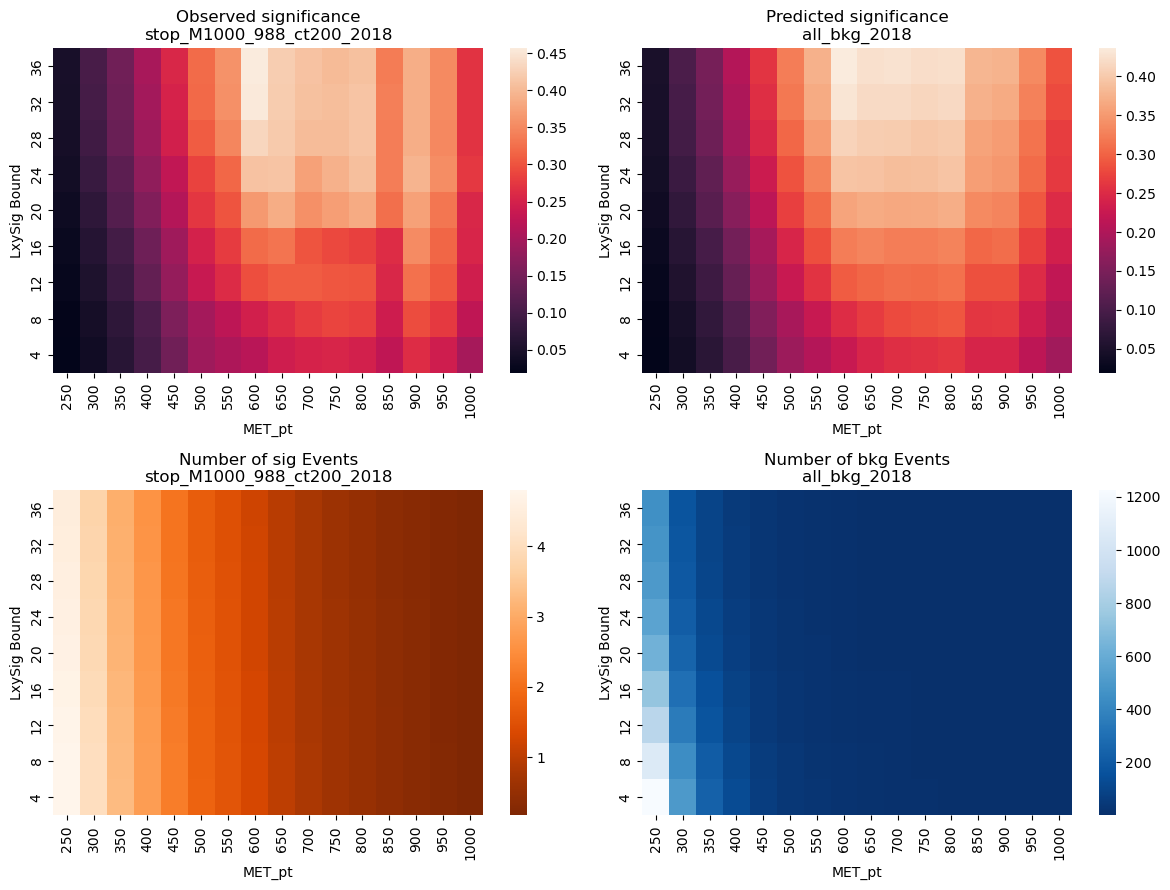

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
tag=sig_tag
# Observed significance plot
sns.heatmap(store[tag + '_signifTable'], ax=axs[0,0])
axs[0,0].set(xlabel='MET_pt', ylabel='LxySig Bound', title='Observed significance\n' + tag)
axs[0,0].set_yticklabels([*map(lambda x: int(float(x.get_text())), axs[0,0].get_yticklabels())])
axs[0,0].invert_yaxis()

# Predicted significance plot
sns.heatmap(store[tag + '_signifpredTable'], ax=axs[0,1])
axs[0,1].set(xlabel='MET_pt', ylabel='LxySig Bound', title='Predicted significance\n' + 'all_bkg_2018')
axs[0,1].set_yticklabels([*map(lambda x: int(float(x.get_text())), axs[0,1].get_yticklabels())])
axs[0,1].invert_yaxis()

# Signal plot
sns.heatmap(store[tag + '_sigTable'], cmap='Oranges_r', ax=axs[1,0])
axs[1,0].set(xlabel='MET_pt', ylabel='LxySig Bound', title='Number of sig Events\n' + tag)
axs[1,0].set_yticklabels([*map(lambda x: int(float(x.get_text())), axs[1,0].get_yticklabels())])
axs[1,0].invert_yaxis()

# Background plot
sns.heatmap(store[tag + '_bkgTable'], cmap='Blues_r', ax=axs[1,1])
axs[1,1].set(xlabel='MET_pt', ylabel='LxySig Bound', title='Number of bkg Events\n' + 'all_bkg_2018')
axs[1,1].set_yticklabels([*map(lambda x: int(float(x.get_text())), axs[1,1].get_yticklabels())])
axs[1,1].invert_yaxis()

fig.tight_layout()
fig.show()


### Max significance

In [44]:
df = store[tag + '_signifpredTable']
df_values = df.values
np.max(df_values[~np.isnan(df_values)])

1.3950024050421752

In [ ]:
store[tag + '_signifTable'][]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
4.0,0.019352,0.039205,0.066346,0.099879,0.145248,0.190744,0.206925,0.218534,0.241905,0.250674,0.254330,0.247118,0.224753,0.263742,0.241925,0.199560
8.0,0.022269,0.044511,0.073974,0.108201,0.158333,0.197643,0.223325,0.245830,0.263051,0.277919,0.287375,0.282379,0.240292,0.293448,0.276189,0.225392
12.0,0.026764,0.054568,0.087632,0.130905,0.183518,0.234329,0.260764,0.295002,0.307887,0.307888,0.303136,0.299935,0.256908,0.326966,0.304691,0.243659
16.0,0.031226,0.062274,0.097235,0.142578,0.192379,0.249581,0.279169,0.321375,0.329031,0.299995,0.289816,0.283121,0.262617,0.351705,0.315914,0.253703
20.0,0.036155,0.073784,0.115233,0.162045,0.213039,0.273208,0.300128,0.365116,0.386813,0.357514,0.371012,0.384048,0.324305,0.374995,0.332351,0.256625
24.0,0.040828,0.084956,0.124033,0.176837,0.227421,0.286006,0.318090,0.410055,0.412411,0.374167,0.391651,0.405964,0.338667,0.395305,0.353276,0.274532
28.0,0.044332,0.094602,0.137808,0.189374,0.245462,0.307786,0.346961,0.431933,0.418284,0.403255,0.404001,0.411578,0.339111,0.387618,0.348731,0.269657
32.0,0.046676,0.098535,0.142130,0.196916,0.251064,0.319756,0.356836,0.454691,0.420394,0.407758,0.404400,0.411865,0.339388,0.388216,0.349499,0.270317
36.0,0.048039,0.102519,0.145872,0.201896,0.256292,0.321087,0.359353,0.457255,0.421539,0.410303,0.402191,0.409179,0.336437,0.388216,0.349499,0.270317


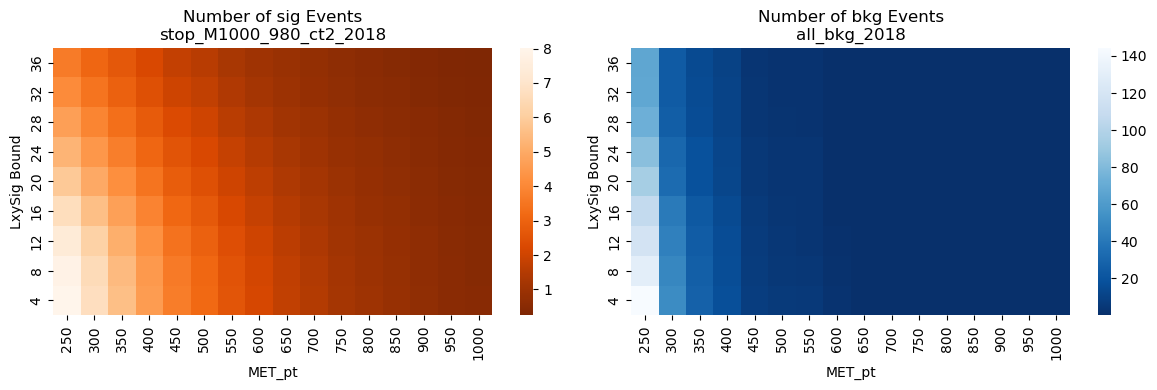

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Signal plot
sns.heatmap(store[tag + '_sigTable'], cmap='Oranges_r', ax=axs[0])
axs[0].set(xlabel='MET_pt', ylabel='LxySig Bound', title='Number of sig Events\n' + tag)
axs[0].set_yticklabels([*map(lambda x: int(float(x.get_text())), s.get_yticklabels())])
axs[0].invert_yaxis()

# Background plot
sns.heatmap(store[tag + '_bkgTable'], cmap='Blues_r', ax=axs[1])
axs[1].set(xlabel='MET_pt', ylabel='LxySig Bound', title='Number of bkg Events\n' + 'all_bkg_2018')
axs[1].set_yticklabels([*map(lambda x: int(float(x.get_text())), s.get_yticklabels())])
axs[1].invert_yaxis()

fig.tight_layout()
fig.show()


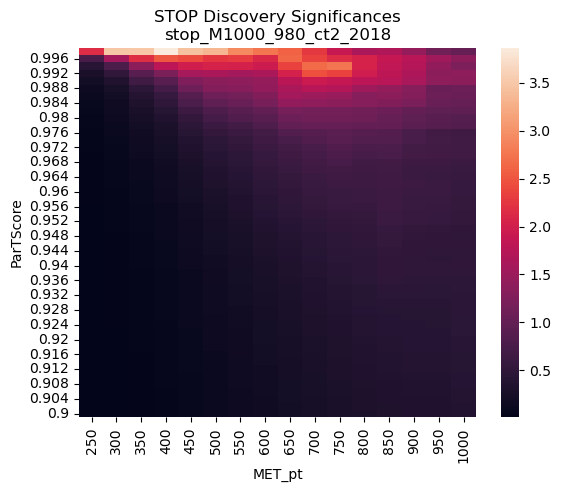

In [17]:
s = sns.heatmap(store[tag + '_signifTable'])
s.set(xlabel='MET_pt', ylabel='ParTScore', title='STOP Discovery Significances\n'+tag);
s.set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), s.get_yticklabels())])
s.invert_yaxis();

In [18]:
# store[tag + '_signifTable']

In [57]:
df = store[tag + '_signifTable']
df_values = df.values
np.max(df_values[~np.isnan(df_values)])

3.867

In [64]:
df[~df.isna()]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.900,0.010,0.020,0.033,0.052,0.076,0.107,0.135,0.165,0.200,0.237,0.268,0.293,0.317,0.329,0.335,0.365
0.902,0.010,0.020,0.034,0.053,0.078,0.109,0.139,0.170,0.205,0.243,0.273,0.298,0.320,0.332,0.338,0.369
0.904,0.011,0.021,0.035,0.054,0.079,0.110,0.141,0.173,0.209,0.247,0.278,0.306,0.327,0.339,0.341,0.372
0.906,0.011,0.021,0.035,0.055,0.081,0.113,0.145,0.178,0.216,0.253,0.283,0.310,0.332,0.344,0.346,0.376
0.908,0.011,0.022,0.036,0.056,0.083,0.115,0.147,0.180,0.217,0.255,0.288,0.316,0.339,0.354,0.355,0.391
0.910,0.011,0.022,0.037,0.057,0.084,0.118,0.151,0.185,0.224,0.263,0.297,0.328,0.351,0.362,0.362,0.401
0.912,0.012,0.023,0.038,0.059,0.087,0.121,0.154,0.190,0.229,0.268,0.303,0.339,0.359,0.372,0.372,0.403
0.914,0.012,0.023,0.039,0.060,0.089,0.125,0.160,0.195,0.235,0.274,0.308,0.344,0.363,0.376,0.378,0.412
0.916,0.012,0.024,0.040,0.062,0.091,0.128,0.164,0.200,0.240,0.280,0.313,0.351,0.368,0.382,0.383,0.415
0.918,0.012,0.024,0.041,0.063,0.094,0.131,0.167,0.204,0.245,0.283,0.317,0.354,0.375,0.388,0.390,0.426


In [23]:
store[tag + '_sigTable'][0.992:]

NameError: name 'tag' is not defined

In [60]:
store[tag + '_bkgTable'][0.992:]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.992,371.181,151.202,63.422,32.810,16.139,11.286,8.420,5.380,2.258,0.887,0.560,0.611,0.486,0.355,0.272,0.170
0.994,196.533,81.155,29.982,14.913,8.664,5.664,3.828,2.863,1.095,0.465,0.218,0.396,0.327,0.208,0.166,0.166
0.996,80.915,24.383,10.585,5.563,3.936,3.116,1.890,1.483,0.477,0.430,0.324,0.239,0.173,0.109,0.069,0.069
0.998,9.852,2.381,1.500,0.632,0.519,0.316,0.291,0.193,0.135,0.135,0.135,0.135,0.070,0.057,0.057,0.057


In [61]:
store[tag + '_bkgpredTable'][0.992:]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.992,340.011,154.413,75.136,39.066,21.675,12.585,7.652,4.827,3.130,2.078,1.400,0.966,0.675,0.473,0.337,0.244
0.994,182.654,82.354,40.476,20.979,11.571,6.725,4.091,2.577,1.671,1.109,0.747,0.516,0.360,0.253,0.180,0.130
0.996,59.031,30.717,14.607,7.552,4.149,2.408,1.470,0.926,0.602,0.399,0.269,0.186,0.130,0.091,0.065,0.047
0.998,12.324,5.490,2.464,1.275,0.696,0.405,0.246,0.155,0.100,0.067,0.045,0.031,0.022,0.015,0.011,0.008


In [49]:
store[tag + '_bkgpredTable'][0.992:] / store[tag + '_bkgTable'][0.992:]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.992,0.916024,1.021236,1.184711,1.190678,1.343003,1.115077,0.908712,0.897122,1.386066,2.343597,2.501320,1.580172,1.387696,1.334707,1.241052,1.432149
0.994,0.929380,1.014775,1.349989,1.406752,1.335572,1.187311,1.068767,0.900050,1.525728,2.387654,3.428721,1.303238,1.102658,1.215218,1.083086,0.783314
0.996,0.729542,1.259798,1.380027,1.357497,1.054126,0.772710,0.777780,0.624507,1.262470,0.929047,0.829071,0.778481,0.748910,0.831723,0.934718,0.676041
0.998,1.250941,2.305907,1.642860,2.016810,1.342223,1.280819,0.845022,0.802531,0.741716,0.491648,0.331063,0.228556,0.309691,0.268323,0.191122,0.138231


In [50]:
store[tag + '_bkgpredUncTable'][0.992:]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.992,22.608757,8.690250,3.987687,2.009431,1.096163,0.633689,0.384313,0.241802,0.156367,0.103796,0.069995,0.048418,0.033888,0.023860,0.017078,0.012424
0.994,18.099348,6.913669,3.205182,1.613522,0.879060,0.508136,0.308051,0.193725,0.125235,0.083069,0.055975,0.038677,0.027030,0.018992,0.013558,0.009831
0.996,8.285269,3.921680,1.865693,0.938813,0.511556,0.295545,0.179219,0.112669,0.072817,0.048276,0.032516,0.022456,0.015682,0.011008,0.007847,0.005681
0.998,5.631895,1.820603,0.793396,0.398047,0.217248,0.125449,0.076028,0.047794,0.030874,0.020466,0.013782,0.009515,0.006642,0.004660,0.003319,0.002401


In [51]:
store[tag + '_bkgUncTable'][0.992:]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.992,27.732482,15.265945,6.174329,4.231936,2.979552,2.282705,1.873984,1.450633,0.838655,0.479560,0.466813,0.165760,0.145832,0.128079,0.114829,0.089867
0.994,22.314324,12.929929,4.370446,2.841417,2.209911,1.569743,1.410760,1.211864,0.689063,0.462504,0.451730,0.136606,0.119892,0.098375,0.089833,0.089833
0.996,16.173062,8.613418,2.438424,1.577224,1.099651,0.869235,0.559525,0.546996,0.136922,0.132440,0.117477,0.104563,0.081571,0.070493,0.058004,0.058004
0.998,2.104737,1.137729,0.829251,0.705665,0.154350,0.120536,0.119283,0.104902,0.087499,0.087499,0.087499,0.087499,0.058107,0.056571,0.056571,0.056571


In [59]:
store[tag + '_bkgUncTable'].loc[0.998:,1000]

0.998    0.056571
Name: 1000, dtype: float64

In [60]:
store[tag + '_bkgTable'].loc[0.998:,1000]

0.998    0.056571
Name: 1000, dtype: float64

In [54]:
store[tag + '_bkgpredUncTable'].loc[0.998:,1000]

0.998    0.002401
Name: 1000, dtype: float64

In [55]:
store[tag + '_bkgpredTable'].loc[0.998:,1000]

0.998    0.00782
Name: 1000, dtype: float64

In [56]:
(store[tag + '_bkgpredTable'].loc[0.998:,1000]/ store[tag + '_bkgpredUncTable'].loc[0.998:,1000])**2

0.998    10.605589
Name: 1000, dtype: float64

In [64]:
(0.00782 / 0.002401)**2

10.607894357498205

In [65]:
(0.056571 / 0.056571)**2

1.0

In [61]:
ufloat(0.00782, 0.002401) / ufloat(0.056571, 0.056571)

0.13823337045482667+/-0.14460224239263791

In [66]:
import ROOT

# --- 1. create one‑bin histograms with your Poisson counts ------------------
h_num = ROOT.TH1D("num","",1,0,1)   # numerator: n1
h_den = ROOT.TH1D("den","",1,0,1)   # denominator: n2
h_num.SetBinContent(1, 10)          # e.g. n1 = 10
h_den.SetBinContent(1, 1)          # e.g. n2 = 73   (change to your numbers)

# --- 2. build the ratio of Poisson means with 68.3 % (1 σ) Clopper‑Pearson --
g = ROOT.TGraphAsymmErrors()
g.Divide(h_num, h_den, "pois cp")   # add "v" for verbose output if you like

# --- 3. access the central value and asymmetric errors ----------------------
ratio      = g.GetY()[0]            # τ̂  = n1 / n2
err_low    = g.GetErrorYlow(0)      # downward error
err_high   = g.GetErrorYhigh(0)     # upward   error
print(f"τ = {ratio:.6f}  +{err_high:.6f}/-{err_low:.6f}")

# optional: draw the graph (as a single point)
# c = ROOT.TCanvas()
# g.SetMarkerStyle(20)
# g.Draw("AP")
# c.Update()


τ = 10.000000  +53.175748/-7.299097


Warning in <TFile::Append>: Replacing existing TH1: num (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: den (Potential memory leak).


In [ ]:
g.Divide(h_num, h_den, "pois fc")                   # Feldman‑Cousins 68 % CL
g.Divide(h_num, h_den, "pois b(0.5,0.5) shortest")  # Bayesian Jeffreys prior

In [69]:
from uncertainties import ufloat

def ratio_gauss(muA, sigA, muB, sigB):
    """
    Return R = A/B with its propagated 1‑sigma error,
    assuming A and B are independent Gaussians.
    """
    a = ufloat(muA, sigA)
    b = ufloat(muB, sigB)
    return a / b

# example -------------------------------------------------------------
ra = ratio_gauss(0.00782,   0.002401,
                 0.056571,  0.056571)
print(ra)        # ==> 0.138233±0.144602

0.14+/-0.14


In [55]:
from scipy import stats
import numpy as np

my_dict = {}
my_val = 0.7

mu1s = []
mu2s = []

trial1s = np.random.uniform(0, 300, 10000)
trial2s = np.random.uniform(0, 300, 10000)

for mu1, mu2 in zip(trial1s, trial2s):
    rvs1 = stats.poisson.rvs(mu1, size=1000)
    rvs2 = stats.poisson.rvs(mu2, size=1000)
    rvs_ratio = rvs1 / rvs2
    x = np.percentile(rvs_ratio, [16, 84])
    if np.isnan(x[0]) or np.isnan(x[1]):
        continue
    if x[0] <= my_val <= x[1]:
        # print(f"my_val is inside the range of x: {x[0]:.2f} <= {my_val:.2f} <= {x[1]:.2f}")
        mu1s.append(mu1)
        mu2s.append(mu2)
        
        # my_dict[f'{mu1:.2f}_{mu2:.2f}'] = x

/tmp/ipykernel_4077/569524839.py:16: RuntimeWarning: divide by zero encountered in divide
  rvs_ratio = rvs1 / rvs2
/tmp/ipykernel_4077/569524839.py:16: RuntimeWarning: invalid value encountered in divide
  rvs_ratio = rvs1 / rvs2


In [56]:
rvs1 = stats.poisson.rvs(200, size=1000)
rvs2 = stats.poisson.rvs(300, size=1000)
rvs_ratio = rvs1 / rvs2
x = np.percentile(rvs_ratio, [16, 84])
x

array([0.60688449, 0.72831056])

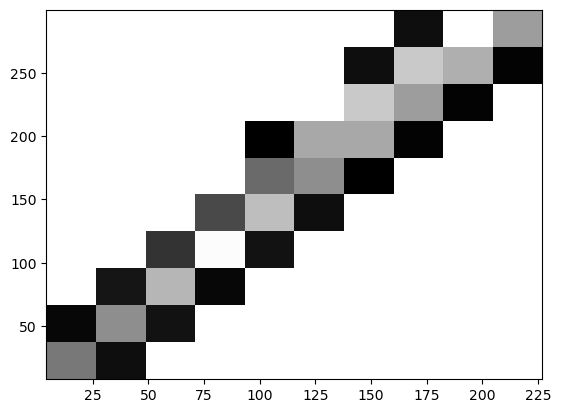

In [57]:
import matplotlib.pyplot as plt
plt.hist2d(mu1s, mu2s, cmin = 1, cmap='gray')
plt.show()

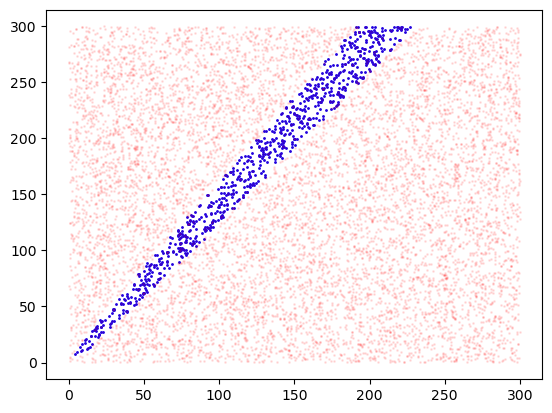

In [59]:
plt.plot(mu1s, mu2s, 'o', markersize=1, color="blue")
plt.plot(trial1s, trial2s, 'o', markersize=1, color="red", alpha=0.1)

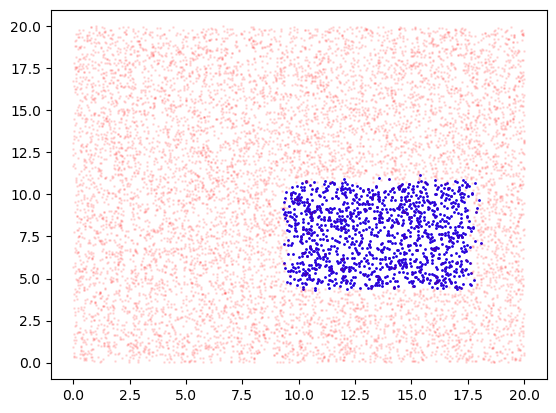

In [141]:
from scipy import stats
import numpy as np

bin1_obs = 13
bin2_obs =  7

mu1s = []
mu2s = []

trial1s = np.random.uniform(0, 20, 10000)
trial2s = np.random.uniform(0, 20, 10000)

for mu1, mu2 in zip(trial1s, trial2s):
    rvs1 = stats.poisson.rvs(mu1, size=1000)
    rvs2 = stats.poisson.rvs(mu2, size=1000)
    bin1_ci = np.percentile(rvs1, [16, 84])
    bin2_ci = np.percentile(rvs2, [16, 84])

    if np.isnan(bin1_ci[0]) or np.isnan(bin1_ci[1]):
        continue
    if bin1_ci[0] <= bin1_obs <= bin1_ci[1]:
        mu1s.append(mu1)
    else: mu1s.append(np.nan)
    if bin2_ci[0] <= bin2_obs <= bin2_ci[1]:
        mu2s.append(mu2)
    else: mu2s.append(np.nan)

plt.plot(mu1s, mu2s, 'o', markersize=1, color="blue")
plt.plot(trial1s, trial2s, 'o', markersize=1, color="red", alpha=0.1)

0.014


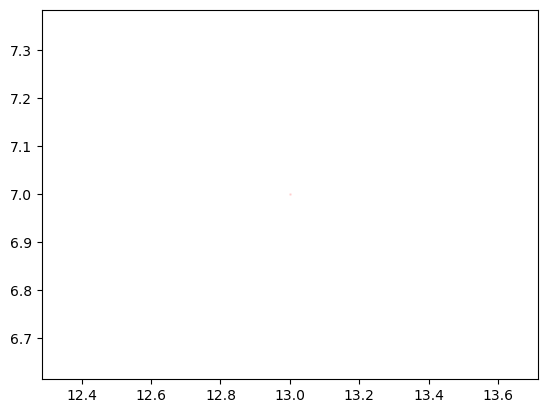

In [159]:
from scipy import stats
import numpy as np

bin1_obs = 13
bin2_obs =  7
n = 10000
N = 1000
CL=0.95
alpha = 1-CL

mu1s = []
mu2s = []

# trial1s = np.random.uniform(0, 20, n)
# trial2s = np.random.uniform(0, 20, n)

trial1s = [13]
trial2s = [7]

for mu1, mu2 in zip(trial1s, trial2s):
    rvs1 = stats.poisson.rvs(mu1, size=N)
    rvs2 = stats.poisson.rvs(mu2, size=N)

    cond1 = (rvs1 == bin1_obs)
    cond2 = (rvs2 == bin2_obs)
    print(np.sum(cond1 & cond2) / N)

    # if (np.sum(cond1 & cond2) / N > alpha):
    #     mu1s.append(mu1)
    #     mu2s.append(mu2)

plt.plot(mu1s, mu2s, 'o', markersize=1, color="blue")
plt.plot(trial1s, trial2s, 'o', markersize=1, color="red", alpha=0.1)

In [160]:
rvs1

array([14, 16, 14, 13, 18, 13, 13, 13, 13,  4,  8, 12,  9,  9,  8, 12,  7,
        7, 19, 16, 10,  7,  9,  9, 10, 15, 18,  6, 13, 14,  9, 17, 10, 12,
       15, 14,  9, 14, 12, 19, 16, 20, 11, 20, 14, 10, 12, 15, 15, 11, 11,
       10, 13, 12, 23, 13, 16, 11, 13, 17, 18, 19, 16, 16,  6, 16,  7, 15,
       19, 19, 16, 14, 11, 14, 10, 15, 10, 13, 16, 14, 13, 15, 14,  7, 14,
       18, 18, 12, 11, 13,  9, 12, 14, 11, 14,  7, 12, 15, 17, 12,  9,  9,
        8, 11,  8, 10, 19, 16, 17, 20, 14, 10, 15, 11, 16,  9, 11, 10, 14,
        9,  9, 24, 15, 13, 16, 11, 17,  8, 13,  7,  7, 14, 16, 11, 13, 10,
       18, 15,  7,  9, 16, 14, 15, 16, 17, 12, 12, 16, 16,  8, 15, 15,  9,
       13, 12, 12, 10, 12, 14, 13, 17, 15,  9, 16, 11, 11, 13, 17,  9,  9,
       14, 11, 14,  9, 11, 10, 12, 18, 12,  5, 12, 14, 14, 18,  6, 18, 12,
       10, 14, 12, 19, 12,  8, 12, 10, 12, 10, 18, 14,  9, 17, 12, 12,  8,
       11, 23,  5, 20, 10, 17, 13,  9, 13, 14, 11, 16, 12, 10,  6, 13, 13,
       12, 10,  7, 15, 11

In [140]:
arr_mu1 = np.array(mu1s)
arr_mu2 = np.array(mu2s)

ratio = arr_mu1 / arr_mu2
ratio[~np.isnan(ratio)]

# plt.plot(arr_mu1[~np.isnan(arr_mu1) & ~np.isnan(arr_mu2)],
#          arr_mu2[~np.isnan(arr_mu1) & ~np.isnan(arr_mu2)],
#          'o', markersize=1, color="blue")
# plt.plot(trial1s, trial2s, 'o', markersize=1, color="red", alpha=0.1)

array([1.26102087, 2.69038378, 1.58884657, ..., 1.94879002, 2.17773441,
       2.18011587])

In [132]:
rvs1 = stats.poisson.rvs(20, size=1000)
rvs2 = stats.poisson.rvs(10, size=1000)
rvs_ratio = rvs1 / rvs2
x = np.percentile(rvs_ratio, [16, 50, 84])
x

array([1.4  , 2.   , 3.125])

In [30]:
store[tag + '_closureUncTable'][0.992:]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.992,0.092,0.118,0.131,0.165,0.257,0.232,0.207,0.246,0.519,1.273,2.090,0.436,0.422,0.487,0.528,0.759
0.994,0.140,0.183,0.224,0.289,0.355,0.341,0.402,0.387,0.967,2.383,7.109,0.460,0.413,0.582,0.591,0.428
0.996,0.178,0.473,0.364,0.420,0.322,0.236,0.249,0.243,0.393,0.308,0.317,0.354,0.364,0.545,0.790,0.571
0.998,0.631,1.341,1.051,2.338,0.579,0.629,0.434,0.501,0.531,0.352,0.237,0.164,0.275,0.281,0.200,0.145


In [65]:
store[tag + '_signifTable'][0.992:]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.992,0.274,0.517,0.892,1.222,1.594,1.633,1.569,1.643,2.034,2.449,2.352,1.970,1.808,1.655,1.380,1.383
0.994,0.430,0.773,1.374,1.800,1.992,2.058,2.034,1.939,2.357,2.669,2.740,2.055,1.846,1.723,1.425,1.244
0.996,0.749,1.564,2.165,2.519,2.420,2.250,2.291,2.116,2.619,2.349,2.162,2.048,1.888,1.769,1.539,1.371
0.998,2.159,3.483,3.491,3.867,3.434,3.330,2.923,2.761,2.588,2.258,1.908,1.649,1.673,1.453,1.130,1.022


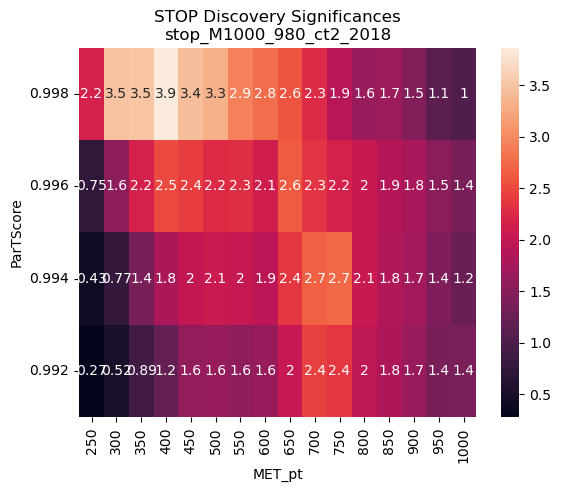

In [ ]:
s = sns.heatmap(store[tag + '_signifTable'][0.992:], annot=True)
s.set(xlabel='MET_pt', ylabel='ParTScore', title='STOP Discovery Significances\n'+tag);
s.set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), s.get_yticklabels())])
s.invert_yaxis();
plt.

In [ ]:
# d.to_csv(sep = "|")
tableName = tag + '_bkgTable'
print(f"Printing {tableName} \n")
d = store[tableName]
s = d.to_markdown()
s = "| ParTScore/MET_pt" + s[6:]
print(s)

In [ ]:
for key in bkg_histDict.keys():
    print(key)

In [ ]:
c = ROOT.TCanvas("c1","myCanvas1",600,600)
h = bkg_histDict['zjetstonunuht2500_2018']
h.Draw("COLZ")
h.GetXaxis().SetRange(-1, 1000)
h.GetYaxis().SetRange(-1, 1000)
c.Draw()

In [ ]:
sig(15.903, 4.079, 0.4513)

In [ ]:
sig(5, 4.079, 0.4513)

In [ ]:
5 / 15.903

In [ ]:
store[tag + '_sigTable']

In [ ]:
tag = 'stop_1000_980_2'

s = sns.heatmap(store[tag + '_bkgTable'], cmap="Blues_r")
s.set(xlabel='MET_pt', ylabel='LxySig', title='STOP Events\n'+tag);
s.invert_yaxis();

In [ ]:
# d.to_csv(sep = "|")
tag = 'stop_1000_980_2'
d = store[tag + '_bkgTable']
s = d.to_markdown()
s = "| LxySig/MET_pt " + s[6:]

In [ ]:
print(f"{s}")

In [ ]:
# hist.GetYaxis().GetBinUpEdge(hist.GetYaxis().GetNbins())

In [ ]:
store['stop_1000_988_200_sigTable']

In [ ]:
store['stop_1000_988_200_bkgTable']

In [ ]:
store['stop_1000_988_200_signifTable']

In [ ]:
def sig(s,b,b_err):
  return np.sqrt(2*((s+b)*np.log(((s+b)*(b+b_err*b_err))/(b*b+(s+b)*b_err*b_err)) - 
                    (b*b/(b_err*b_err))*np.log(1+(b_err*b_err*s)/(b*(b+b_err*b_err)))))

In [ ]:
sig(0.2, 0.5, 1e-154)

In [ ]:
0.2 / np.sqrt(0.5)